5/20 (Mon) | Experiment

# Correlation Analyses of Automatically Calculated UF Measures

## 1. Introduction

This notebook evaluate the reliability of the UF measures calculated based on the proposed annotation system. More specifically, I conduct correlation analyses between manually and automatically calculated measures.
In addition, I conduct the same analyses for different perceived fluency score groups separatelly.

The target measures are follows:
- Speed fluency
    - Articulation rate (AR)
- Breakdown fluency
    - Mid-clause pause ratio (MCPR)
    - End-clause pause ratio (ECPR)
    - Mid-clause pause duration (MCPD)
    - End-clause pause duration (ECPD)
    - Pause ratio (PR)
    - Pause duration (PD)
- Repair fluency
    - Disfluency ratio (DR)
- Composite
    - Speech rate (SR)
    - Mean length of run (MLR)

Note that, in dialogue task, I use mean values of turn-level measures.

Before starting the evaluation, the following code block loads required packages and define global variables.

In [1]:
from typing import List, Tuple, Optional
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from utils.mfr import logit_2_rating

DATA_DIR = Path("/home/matsuura/Development/app/feature_extraction_api/experiment/data")

TASK = ["Arg_Oly", "Cartoon", "RtSwithoutRAA", "RtSwithRAA", "WoZ_Interview"]

TARGET_UF_MEASURES = [
    "articulation_rate", "mid_clause_pause_ratio", "end_clause_pause_ratio",
    "mid_clause_p-dur", "end_clause_p-dur", "pause_ratio", "mean_pause_duration",
    "dysfluency_ratio", "speech_rate", "mean_length_of_run"
]

---

## 2. Define Functions

This section defines functions for correlation analyses.
The following code block defines a function to load measures.

In [2]:
def filter_by_rating(task: str, df_uf: pd.DataFrame, rating_filter: List[int]) -> pd.DataFrame:
    pf_path = DATA_DIR / f"{task}/12_PF_Rating/pf_rating.csv"
    df_pf = pd.read_csv(pf_path)
    uid_list = df_pf["uid"].to_numpy()

    logit_path = pf_path.parent / "logit_all.csv"
    threshold_path = logit_path.parent / "threshold_all.csv"
    
    df_logit = pd.read_csv(logit_path, index_col=0)
    rating_list = logit_2_rating(df_logit["theta"], threshold_path)

    mask = np.full(rating_list.shape, False, dtype=bool)
    for rating in rating_filter:
        mask = mask | (rating_list == rating)
    
    uid_list = uid_list[mask]

    if task != "WoZ_Interview":
        df_uf_filtered = df_uf.loc[uid_list, :]
        return df_uf_filtered

    mask = None
    for uid in uid_list:
        uid_prefix = f"{int(uid):03}_"
        uid_mask = df_uf.index.str.startswith(uid_prefix)
        
        if mask is None:
            mask = uid_mask
        mask = mask | uid_mask

    return df_uf[mask]

def add_pause_ratio(df_uf: pd.DataFrame) -> pd.DataFrame:
    df_uf.loc[:, "pause_ratio"] = df_uf["mid_clause_pause_ratio"] + df_uf["end_clause_pause_ratio"]

    return df_uf

def calculate_mean_uf_measures(df_uf: pd.DataFrame) -> pd.DataFrame:
    data = []

    for uid in range(1, 86):
        uid = str(uid).zfill(3)

        mask = df_uf.index.str.startswith(uid)
        if mask.sum() == 0:
            continue

        df_uf_masked = df_uf[mask]
        mean_uf_measures = df_uf_masked.mean(axis=0, skipna=True)
        
        row = {
            "uid": uid   
        }
        for measure_name in df_uf.columns:
            row[measure_name] = mean_uf_measures[measure_name]
        data.append(row)

    df_uf_mean = pd.DataFrame.from_dict(data).set_index("uid", drop=True)

    return df_uf_mean

def load_measures(task_list: List[str], rating_filter: Optional[List[int]] =None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df_uf_manu_list = []
    df_uf_auto_list = []
    
    for task in task_list:
        uf_manu_path = DATA_DIR / f"{task}/09_UF_Measures/uf_measures_manu_pruned.csv"
        uf_auto_path = uf_manu_path.parent / "uf_measures_auto_pruned.csv"

        df_uf_manu = pd.read_csv(uf_manu_path, index_col="uid")
        df_uf_auto = pd.read_csv(uf_auto_path, index_col="uid")

        if rating_filter is not None:
            df_uf_manu = filter_by_rating(task, df_uf_manu, rating_filter)
            df_uf_auto = filter_by_rating(task, df_uf_auto, rating_filter)

        if task == "WoZ_Interview":
            df_uf_manu = calculate_mean_uf_measures(df_uf_manu)
            df_uf_auto = calculate_mean_uf_measures(df_uf_auto)

        df_uf_manu_list.append(df_uf_manu)
        df_uf_auto_list.append(df_uf_auto)

    df_uf_manu = pd.concat(df_uf_manu_list, axis=0)
    df_uf_auto = pd.concat(df_uf_auto_list, axis=0)

    df_uf_manu = add_pause_ratio(df_uf_manu)
    df_uf_auto = add_pause_ratio(df_uf_auto)

    df_uf_manu = df_uf_manu[TARGET_UF_MEASURES].sort_index()
    df_uf_auto = df_uf_auto[TARGET_UF_MEASURES].sort_index()

    return df_uf_manu, df_uf_auto

The following code block conducts a correlation analysis.

In [3]:
def correlation_analysis(task: str, df_uf_manu: pd.DataFrame, df_uf_auto: pd.DataFrame, pf_group: str ="All") -> pd.DataFrame:
    fig = plt.figure(figsize=(15, 10))    
    ncols = 4
    nrows = (len(TARGET_UF_MEASURES) + ncols - 1) // ncols

    data = []
    columns = ["UF measure", "task", "PF", "r", "p", "sig", "lower", "upper"]
    for i, measure in enumerate(TARGET_UF_MEASURES):
        ax = fig.add_subplot(nrows, ncols, i + 1)

        measure_manu = df_uf_manu[measure]
        measure_auto = df_uf_auto[measure]

        res = pearsonr(measure_manu, measure_auto)
        r = res[0]
        p = res[1]
        lower, upper = res.confidence_interval()
        if p < 0.001:
            sig = "***"
        elif p < 0.01:
            sig = "**"
        elif p < 0.05:
            sig = "*"
        elif p < 0.1:
            sig = "."
        else:
            sig = ""

        data.append([measure, task, pf_group, r, p, sig, lower, upper])

        ax.scatter(measure_manu, measure_auto)
        ax.set_title(f"[{measure}] r={r:.03f}{sig}")
        ax.set_xlabel(f"Manually Calculated Measure")
        ax.set_ylabel(f"Automatically Calculate Measure")

    df_pearsonr = pd.DataFrame(data, columns=columns).set_index("UF measure", drop=True)

    fig.suptitle(f"[{task}] Scatter Plots of Manually and Automatically UF Measures (N={len(df_uf_manu)})", fontweight="bold")
    fig.tight_layout()
    plt.show()

    return df_pearsonr

---

## 3. Correlation Analyses

This section conducts the correlation analyses.

In [4]:
df_cor_list = []

### 3.1. All Speakers

Firstly, UF measures obtained from all tasks are analyzed.

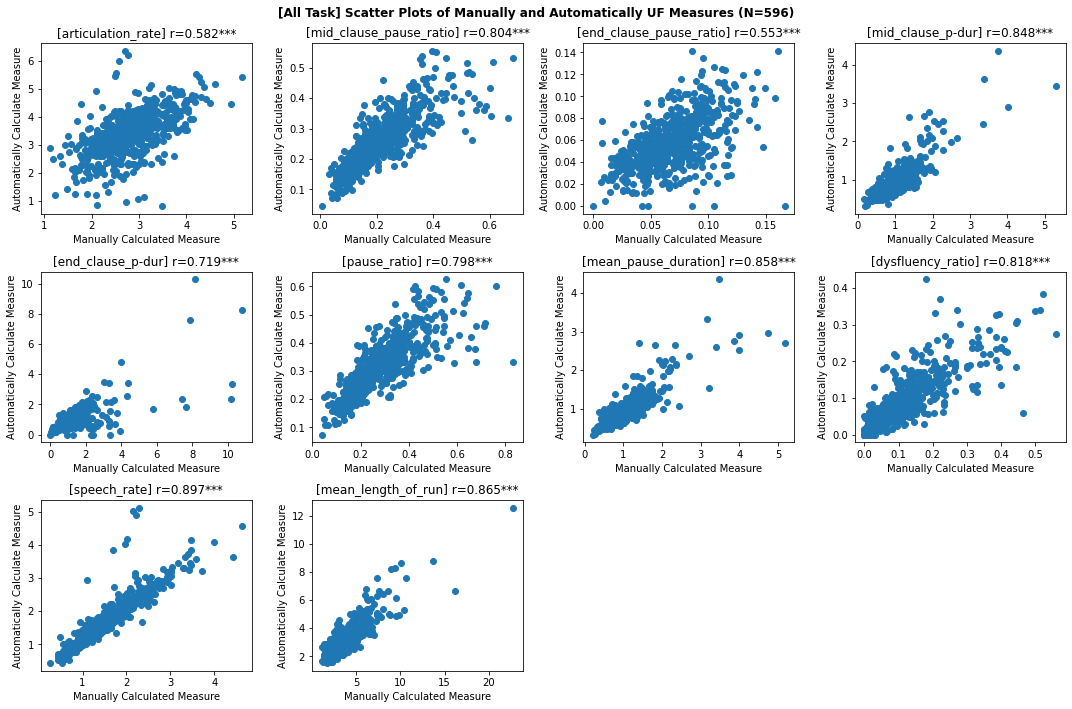

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,All Task,All,0.581867,2.706997e-55,***,0.526142,0.632617
mid_clause_pause_ratio,All Task,All,0.803635,5.318802e-136,***,0.773228,0.830355
end_clause_pause_ratio,All Task,All,0.553370,4.105157e-49,***,0.495059,0.606719
mid_clause_p-dur,All Task,All,0.848405,3.075166e-166,***,0.824256,0.869474
end_clause_p-dur,All Task,All,0.719307,4.809989e-96,***,0.678172,0.755949
pause_ratio,All Task,All,0.797839,1.162666e-132,***,0.766651,0.825271
mean_pause_duration,All Task,All,0.858122,4.118961e-174,***,0.835382,0.877930
dysfluency_ratio,All Task,All,0.817634,1.499073e-144,***,0.789141,0.842615
speech_rate,All Task,All,0.896671,2.236759e-212,***,0.879710,0.911353


In [5]:
df_uf_manu, df_uf_auto = load_measures(TASK)
mask_2055 = df_uf_manu.index.str.startswith("2055_RtSwithoutRAA")
df_uf_manu = df_uf_manu[~mask_2055]
df_uf_auto = df_uf_auto[~mask_2055]
df_pearsonr = correlation_analysis("All Task", df_uf_manu, df_uf_auto)
df_cor_list.append(df_pearsonr)
df_pearsonr

The following five code blocks conduct the analyses for each task.

**Arg_Oly**

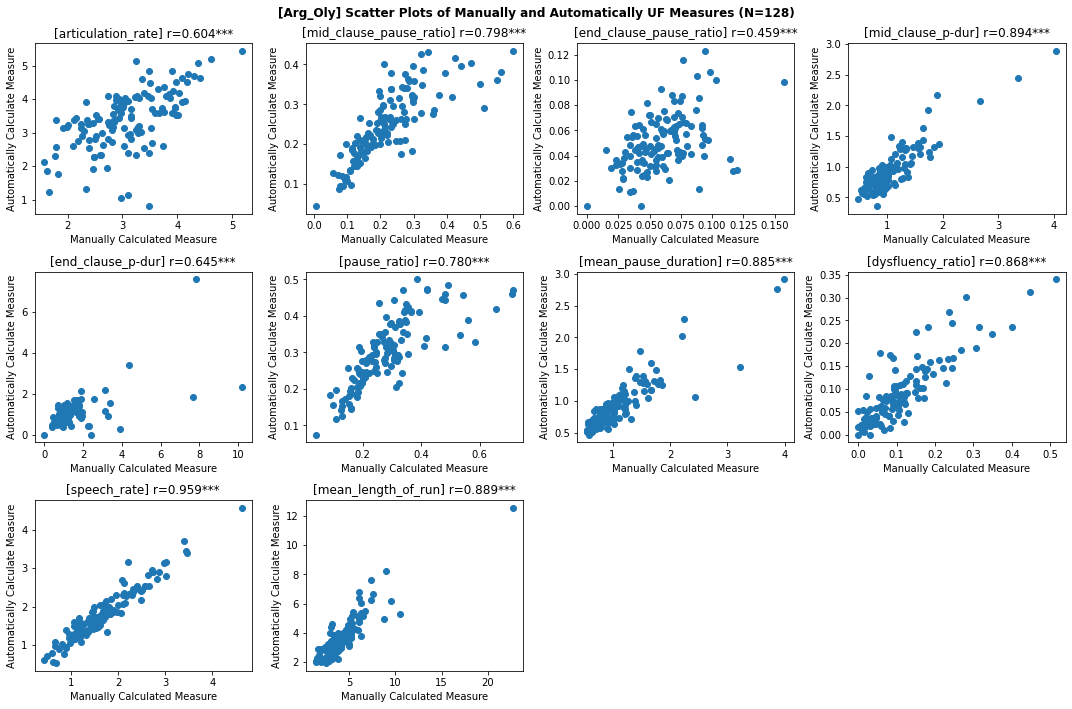

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,Arg_Oly,All,0.603590,4.660326e-14,***,0.480374,0.703441
mid_clause_pause_ratio,Arg_Oly,All,0.798123,1.663451e-29,***,0.725005,0.853452
end_clause_pause_ratio,Arg_Oly,All,0.458654,5.192646e-08,***,0.309779,0.585578
mid_clause_p-dur,Arg_Oly,All,0.894129,8.637202e-46,***,0.852940,0.924254
end_clause_p-dur,Arg_Oly,All,0.645094,2.059634e-16,***,0.531006,0.736210
pause_ratio,Arg_Oly,All,0.779560,2.258493e-27,***,0.700838,0.839522
mean_pause_duration,Arg_Oly,All,0.885212,1.056815e-43,***,0.840845,0.917764
dysfluency_ratio,Arg_Oly,All,0.868332,3.467728e-40,***,0.818069,0.905430
speech_rate,Arg_Oly,All,0.958631,1.296455e-70,***,0.941764,0.970686


In [6]:
task = "Arg_Oly"
df_uf_manu, df_uf_auto = load_measures([task])
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto)
df_cor_list.append(df_pearsonr)
df_pearsonr

**Cartoon**

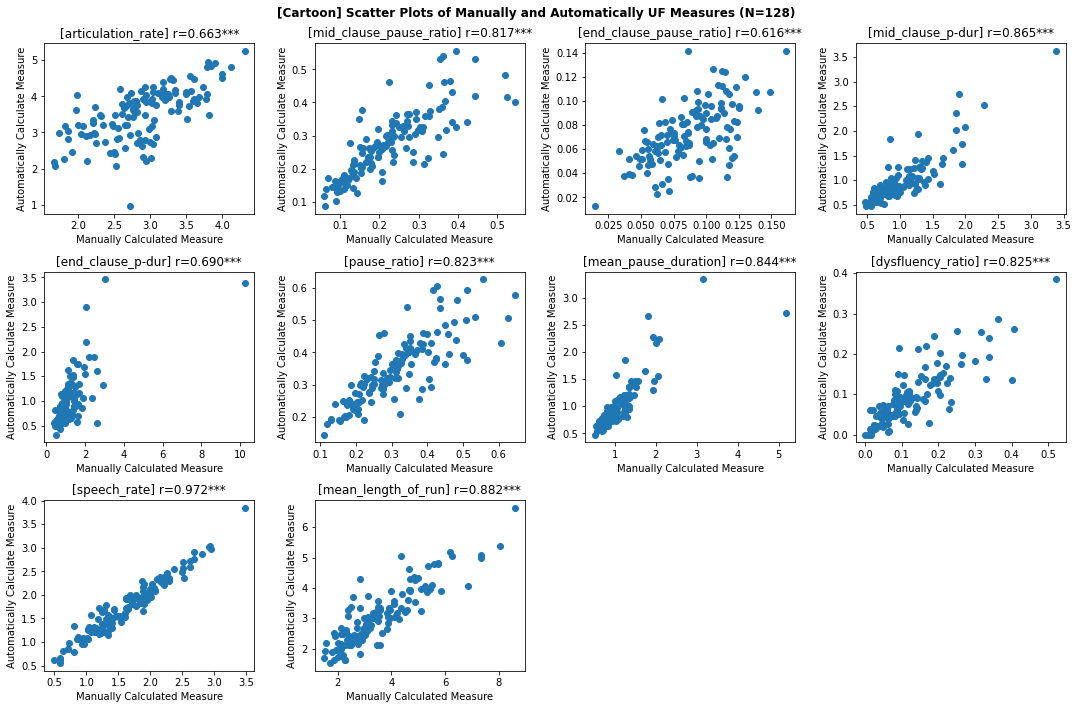

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,Cartoon,All,0.662920,1.539219e-17,***,0.553005,0.750155
mid_clause_pause_ratio,Cartoon,All,0.817323,5.849219e-32,***,0.750193,0.867777
end_clause_pause_ratio,Cartoon,All,0.616133,9.846097e-15,***,0.495590,0.713390
mid_clause_p-dur,Cartoon,All,0.865010,1.495012e-39,***,0.813606,0.902996
end_clause_p-dur,Cartoon,All,0.689903,2.128440e-19,***,0.586600,0.771116
pause_ratio,Cartoon,All,0.823424,8.438912e-33,***,0.758237,0.872311
mean_pause_duration,Cartoon,All,0.844125,6.498815e-36,***,0.785682,0.887634
dysfluency_ratio,Cartoon,All,0.825443,4.373439e-33,***,0.760905,0.873810
speech_rate,Cartoon,All,0.971919,4.907339e-81,***,0.960361,0.980141


In [7]:
task = "Cartoon"
df_uf_manu, df_uf_auto = load_measures([task])
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto)
df_cor_list.append(df_pearsonr)
df_pearsonr

**RtSwithoutRAA**

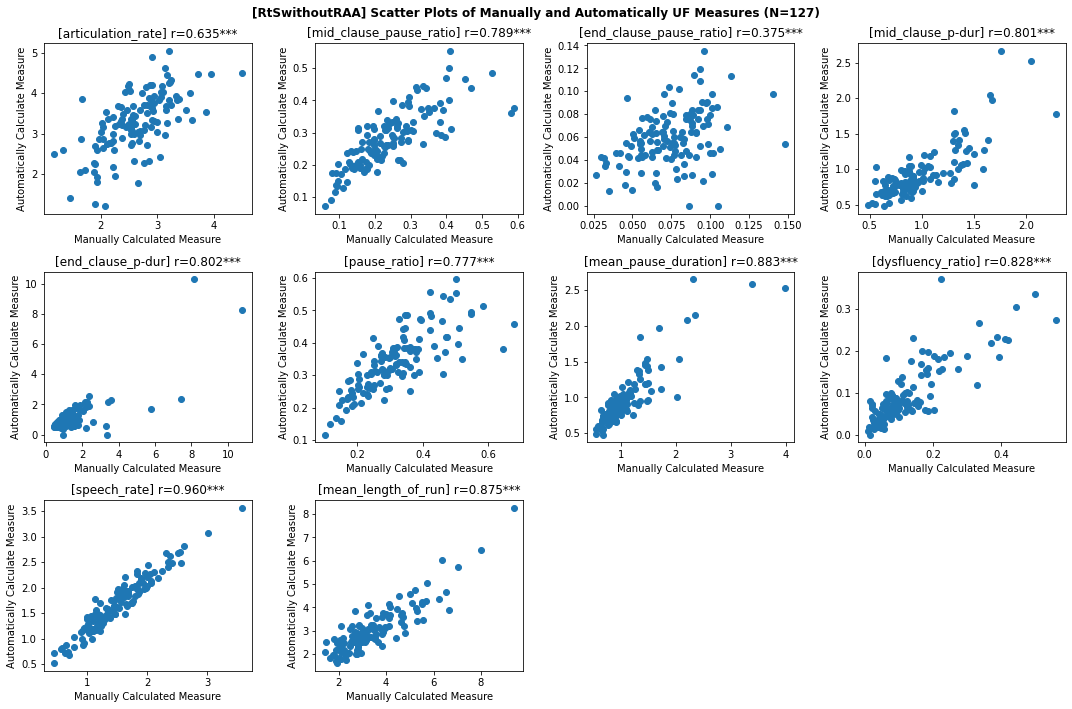

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,RtSwithoutRAA,All,0.635426,1.019035e-15,***,0.518623,0.728946
mid_clause_pause_ratio,RtSwithoutRAA,All,0.789215,3.053521e-28,***,0.713038,0.846976
end_clause_pause_ratio,RtSwithoutRAA,All,0.375232,1.381680e-05,***,0.215077,0.515732
mid_clause_p-dur,RtSwithoutRAA,All,0.801453,1.095805e-29,***,0.729029,0.856131
end_clause_p-dur,RtSwithoutRAA,All,0.802154,8.994249e-30,***,0.729947,0.856654
pause_ratio,RtSwithoutRAA,All,0.776744,7.275500e-27,***,0.696824,0.837613
mean_pause_duration,RtSwithoutRAA,All,0.883161,6.461863e-43,***,0.837859,0.916381
dysfluency_ratio,RtSwithoutRAA,All,0.828335,3.012727e-33,***,0.764434,0.876119
speech_rate,RtSwithoutRAA,All,0.960434,2.984155e-71,***,0.944205,0.972010


In [8]:
task = "RtSwithoutRAA"
df_uf_manu, df_uf_auto = load_measures([task])
mask_2055 = df_uf_manu.index.str.startswith("2055")
df_uf_manu = df_uf_manu[~mask_2055]
df_uf_auto = df_uf_auto[~mask_2055]
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto)
df_cor_list.append(df_pearsonr)
df_pearsonr

**RtSwithRAA**

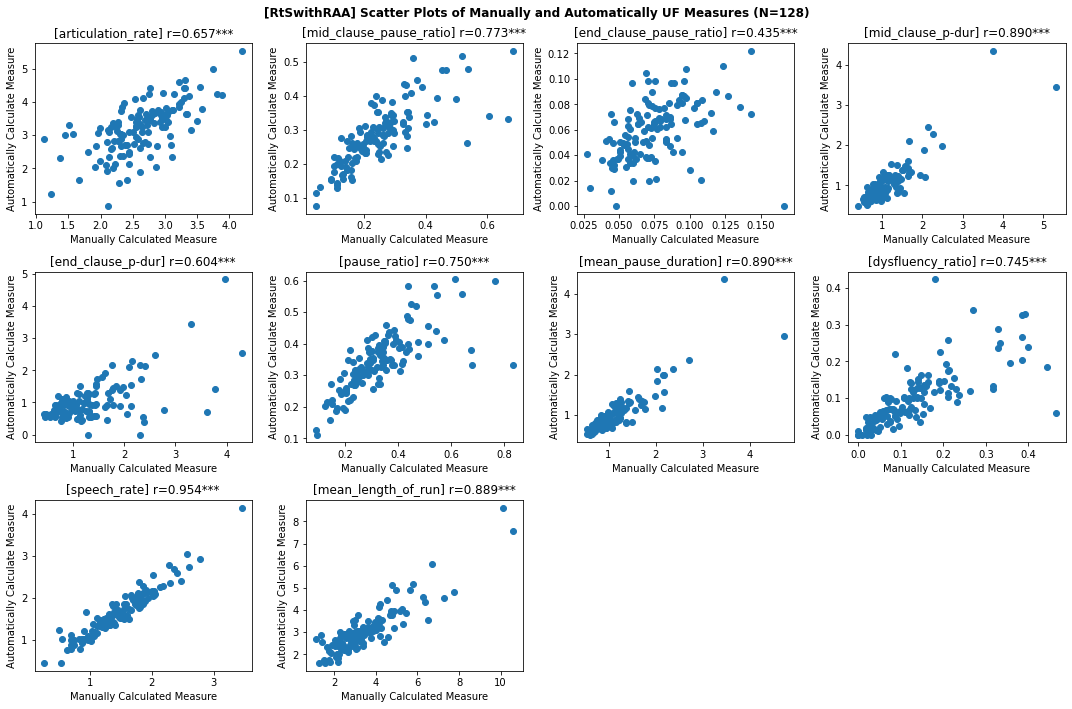

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,RtSwithRAA,All,0.656952,3.740176e-17,***,0.545623,0.745495
mid_clause_pause_ratio,RtSwithRAA,All,0.773241,1.079482e-26,***,0.692652,0.834763
end_clause_pause_ratio,RtSwithRAA,All,0.434886,2.904445e-07,***,0.282689,0.565724
mid_clause_p-dur,RtSwithRAA,All,0.890385,6.839372e-45,***,0.847855,0.921530
end_clause_p-dur,RtSwithRAA,All,0.604366,4.241141e-14,***,0.481314,0.704058
pause_ratio,RtSwithRAA,All,0.749655,2.439831e-24,***,0.662279,0.816915
mean_pause_duration,RtSwithRAA,All,0.890003,8.407834e-45,***,0.847338,0.921253
dysfluency_ratio,RtSwithRAA,All,0.744658,7.123348e-24,***,0.655881,0.813117
speech_rate,RtSwithRAA,All,0.953946,9.643402e-68,***,0.935233,0.967344


In [9]:
task = "RtSwithRAA"
df_uf_manu, df_uf_auto = load_measures([task])
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto)
df_cor_list.append(df_pearsonr)
df_pearsonr

**WoZ_Interview**

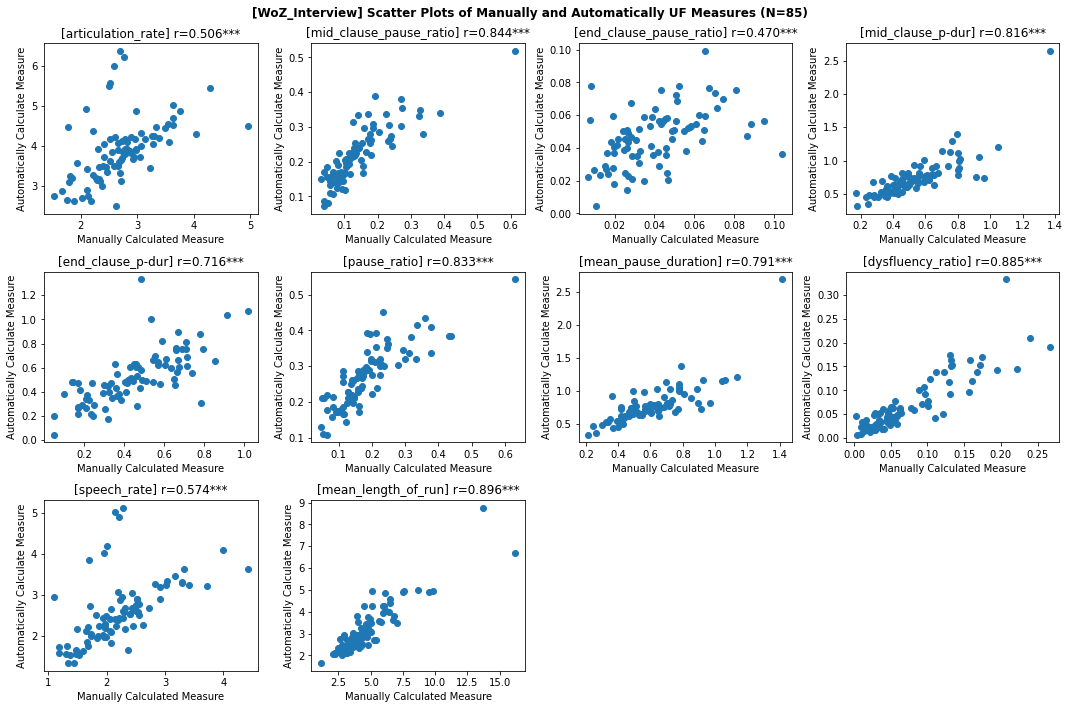

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,WoZ_Interview,All,0.505805,7.897640e-07,***,0.328044,0.648971
mid_clause_pause_ratio,WoZ_Interview,All,0.843644,3.928584e-24,***,0.768740,0.895717
end_clause_pause_ratio,WoZ_Interview,All,0.470214,5.607791e-06,***,0.285724,0.621096
mid_clause_p-dur,WoZ_Interview,All,0.815942,1.884664e-21,***,0.729713,0.876624
end_clause_p-dur,WoZ_Interview,All,0.715630,1.400914e-14,***,0.592940,0.805848
pause_ratio,WoZ_Interview,All,0.832940,4.876290e-23,***,0.753594,0.888363
mean_pause_duration,WoZ_Interview,All,0.791283,2.031118e-19,***,0.695439,0.859465
dysfluency_ratio,WoZ_Interview,All,0.884638,3.093951e-29,***,0.827535,0.923624
speech_rate,WoZ_Interview,All,0.574353,9.064875e-09,***,0.411614,0.701596


In [10]:
task = "WoZ_Interview"
df_uf_manu, df_uf_auto = load_measures([task])
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto)
df_cor_list.append(df_pearsonr)
df_pearsonr

### 3.2. Beginners

The following code blocks conduct the analyses of *beginners'* speech.

**Arg_Oly**

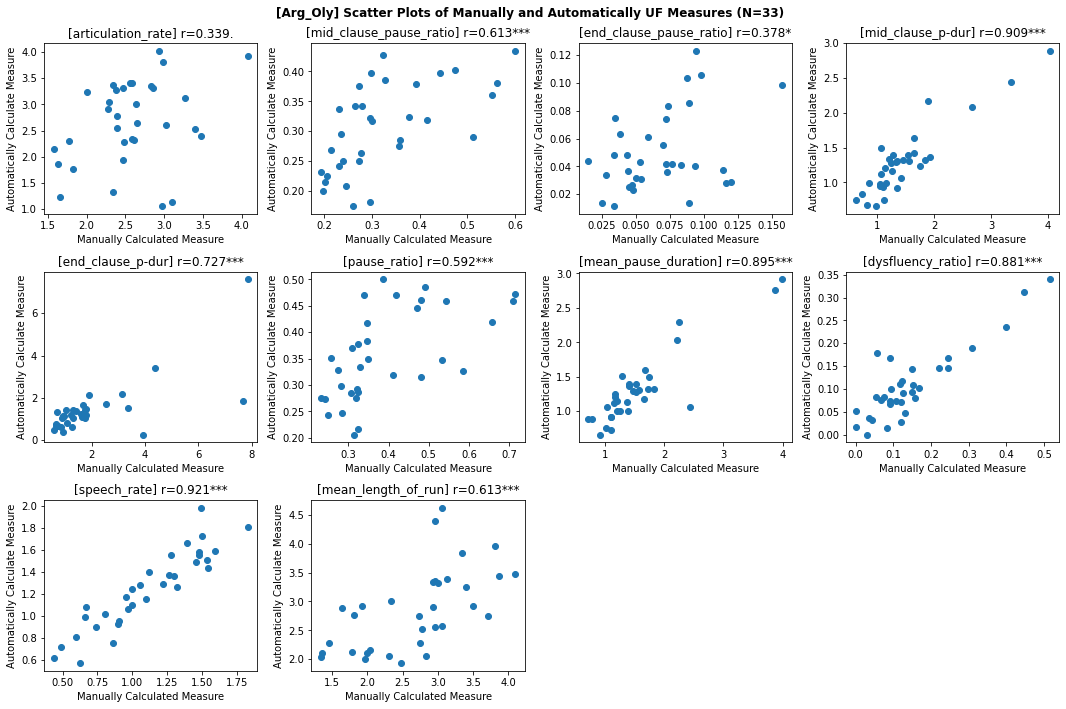

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,Arg_Oly,Low,0.339295,5.339867e-02,.,-0.004544,0.611387
mid_clause_pause_ratio,Arg_Oly,Low,0.612533,1.513094e-04,***,0.340915,0.789764
end_clause_pause_ratio,Arg_Oly,Low,0.377696,3.023280e-02,*,0.039511,0.638246
mid_clause_p-dur,Arg_Oly,Low,0.909305,2.440124e-13,***,0.822876,0.954611
end_clause_p-dur,Arg_Oly,Low,0.726807,1.670360e-06,***,0.511003,0.856422
pause_ratio,Arg_Oly,Low,0.592293,2.819752e-04,***,0.312535,0.777505
mean_pause_duration,Arg_Oly,Low,0.894709,2.222456e-12,***,0.795856,0.947104
dysfluency_ratio,Arg_Oly,Low,0.880504,1.427386e-11,***,0.769934,0.939743
speech_rate,Arg_Oly,Low,0.920803,3.237614e-14,***,0.844438,0.960484


In [11]:
task = "Arg_Oly"
rating_filter = [0, 1, 2]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto, pf_group="Low")
df_cor_list.append(df_pearsonr)
df_pearsonr

**Cartoon**

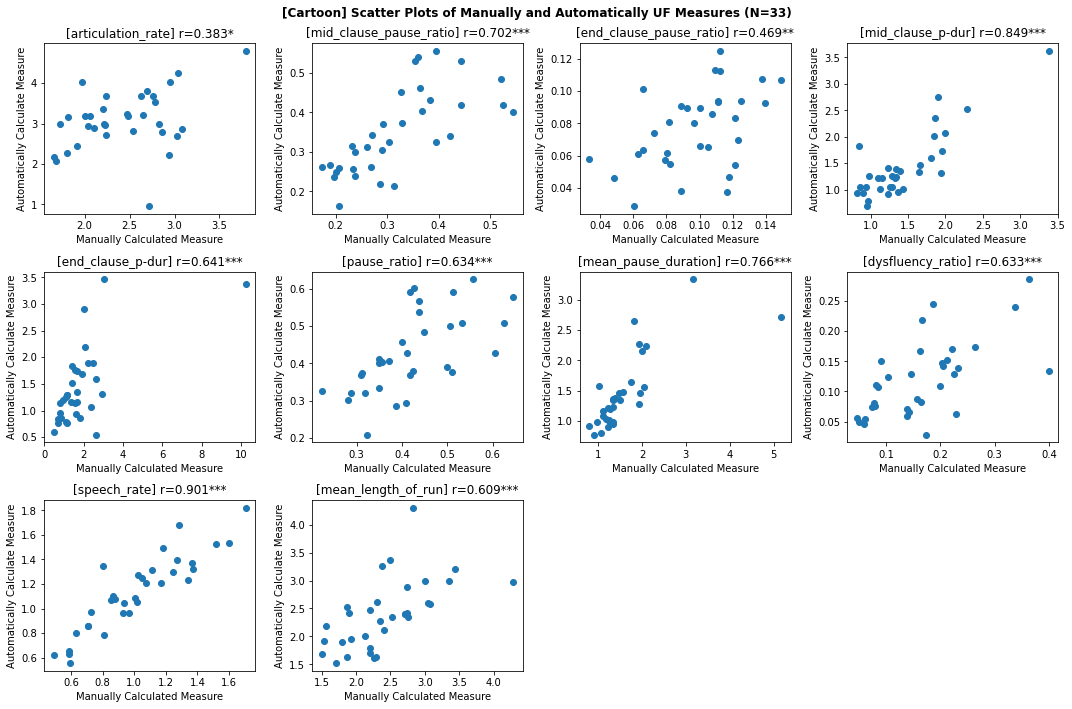

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,Cartoon,Low,0.382760,2.791397e-02,*,0.045419,0.641741
mid_clause_pause_ratio,Cartoon,Low,0.701511,5.411849e-06,***,0.471837,0.842030
end_clause_pause_ratio,Cartoon,Low,0.468819,5.923247e-03,**,0.149586,0.699538
mid_clause_p-dur,Cartoon,Low,0.849031,4.258430e-10,***,0.713773,0.923236
end_clause_p-dur,Cartoon,Low,0.641048,5.835331e-05,***,0.381755,0.806799
pause_ratio,Cartoon,Low,0.634057,7.436086e-05,***,0.371647,0.802647
mean_pause_duration,Cartoon,Low,0.766339,2.005637e-07,***,0.574059,0.878518
dysfluency_ratio,Cartoon,Low,0.632775,7.769066e-05,***,0.369800,0.801885
speech_rate,Cartoon,Low,0.900640,9.438431e-13,***,0.806789,0.950161


In [12]:
task = "Cartoon"
rating_filter = [0, 1, 2]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto, pf_group="Low")
df_cor_list.append(df_pearsonr)
df_pearsonr

**RtSwithoutRAA**

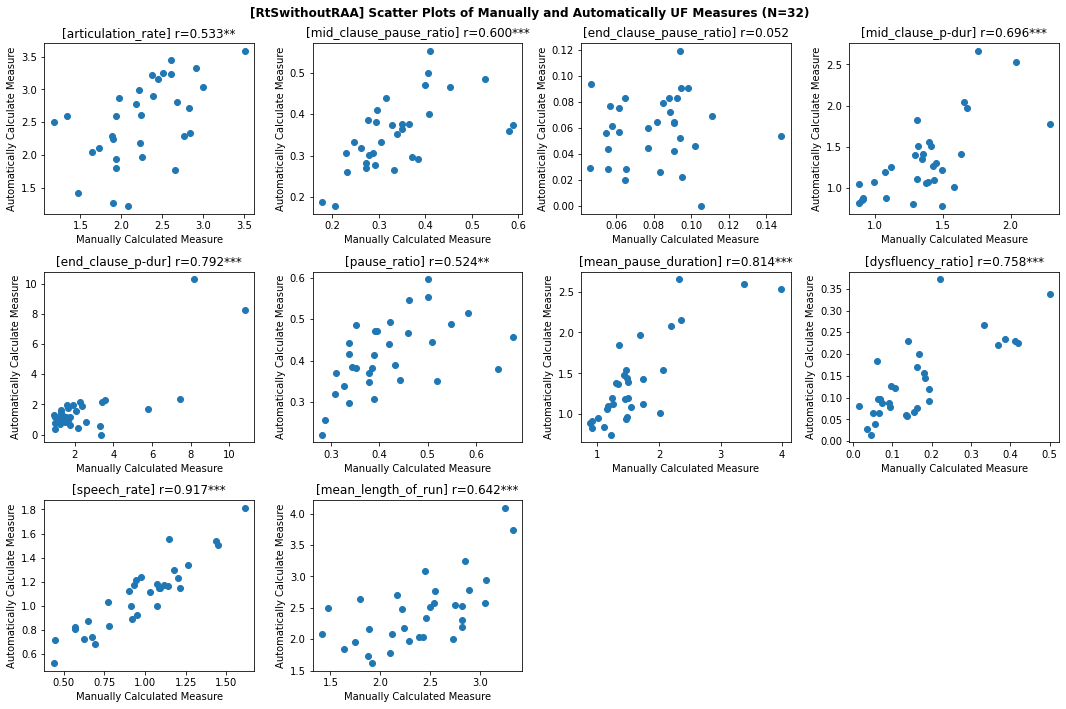

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,RtSwithoutRAA,Low,0.532820,1.691840e-03,**,0.226141,0.743397
mid_clause_pause_ratio,RtSwithoutRAA,Low,0.600196,2.819707e-04,***,0.318070,0.784671
end_clause_pause_ratio,RtSwithoutRAA,Low,0.052117,7.769603e-01,,-0.302066,0.393657
mid_clause_p-dur,RtSwithoutRAA,Low,0.695629,9.883508e-06,***,0.458037,0.840460
end_clause_p-dur,RtSwithoutRAA,Low,0.791560,6.866051e-08,***,0.611703,0.893607
pause_ratio,RtSwithoutRAA,Low,0.523533,2.105501e-03,**,0.213884,0.737580
mean_pause_duration,RtSwithoutRAA,Low,0.814421,1.416690e-08,***,0.650441,0.905864
dysfluency_ratio,RtSwithoutRAA,Low,0.757914,5.070951e-07,***,0.556217,0.875287
speech_rate,RtSwithoutRAA,Low,0.917424,1.542613e-13,***,0.836245,0.959253


In [13]:
task = "RtSwithoutRAA"
rating_filter = [0, 1, 2]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
mask_2055 = df_uf_manu.index.str.startswith("2055")
df_uf_manu = df_uf_manu[~mask_2055]
df_uf_auto = df_uf_auto[~mask_2055]
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto, pf_group="Low")
df_cor_list.append(df_pearsonr)
df_pearsonr

**RtSwithRAA**

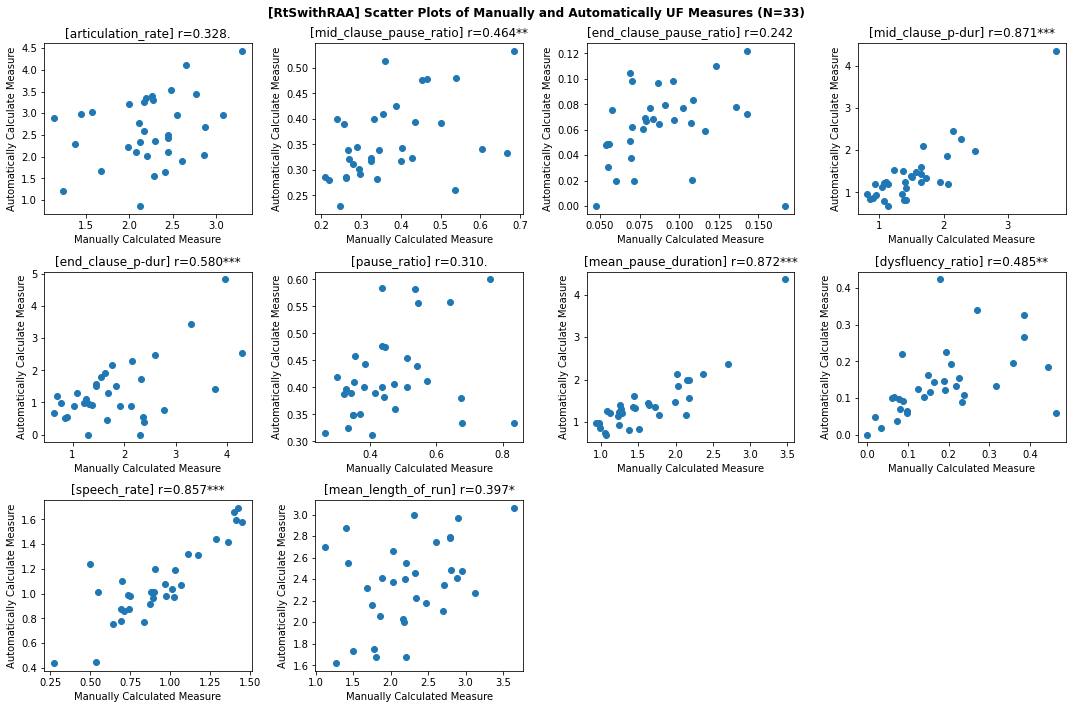

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,RtSwithRAA,Low,0.327898,6.247911e-02,.,-0.017366,0.603294
mid_clause_pause_ratio,RtSwithRAA,Low,0.464229,6.499212e-03,**,0.143846,0.696530
end_clause_pause_ratio,RtSwithRAA,Low,0.242207,1.744498e-01,,-0.110272,0.540567
mid_clause_p-dur,RtSwithRAA,Low,0.871121,4.305217e-11,***,0.753010,0.934850
end_clause_p-dur,RtSwithRAA,Low,0.580472,3.980814e-04,***,0.296187,0.770279
pause_ratio,RtSwithRAA,Low,0.310149,7.898988e-02,.,-0.037112,0.590575
mean_pause_duration,RtSwithRAA,Low,0.871575,4.089547e-11,***,0.753825,0.935087
dysfluency_ratio,RtSwithRAA,Low,0.485353,4.195814e-03,**,0.170445,0.710307
speech_rate,RtSwithRAA,Low,0.856674,2.012388e-10,***,0.727254,0.927270


In [14]:
task = "RtSwithRAA"
rating_filter = [0, 1, 2]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto, pf_group="Low")
df_cor_list.append(df_pearsonr)
df_pearsonr

**WoZ_Interview**

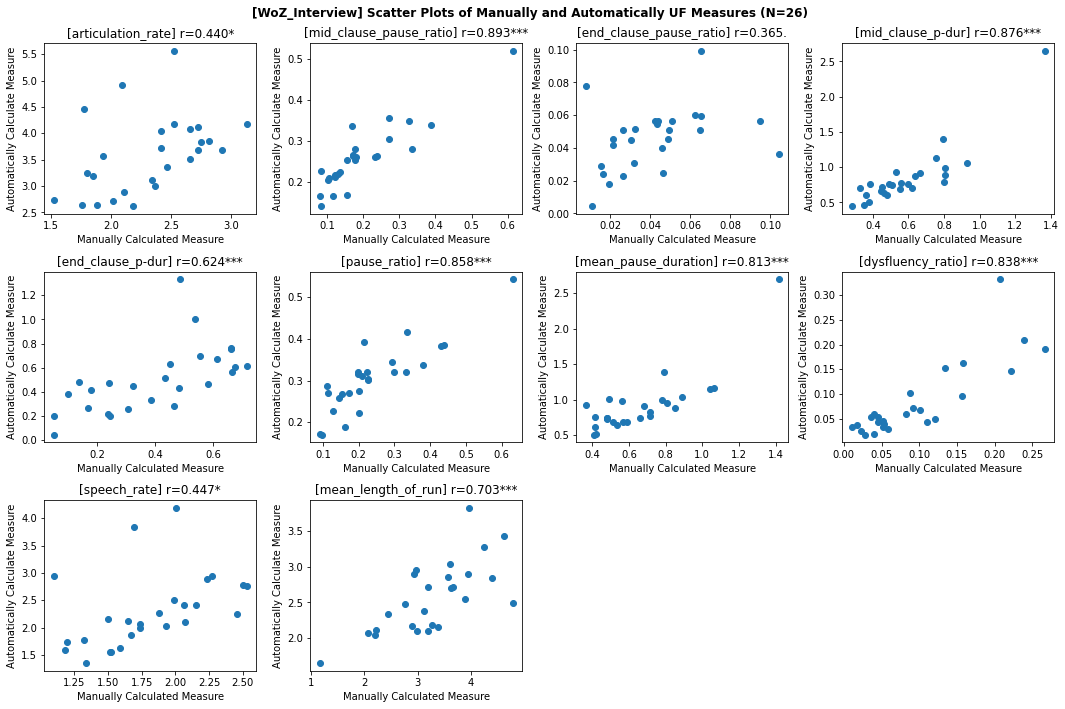

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,WoZ_Interview,Low,0.440002,2.448785e-02,*,0.063467,0.706877
mid_clause_pause_ratio,WoZ_Interview,Low,0.893429,8.142885e-10,***,0.773903,0.951495
end_clause_pause_ratio,WoZ_Interview,Low,0.364973,6.675686e-02,.,-0.026063,0.659141
mid_clause_p-dur,WoZ_Interview,Low,0.876477,4.372576e-09,***,0.740544,0.943505
end_clause_p-dur,WoZ_Interview,Low,0.623999,6.578838e-04,***,0.312079,0.814484
pause_ratio,WoZ_Interview,Low,0.858341,2.052555e-08,***,0.705581,0.934868
mean_pause_duration,WoZ_Interview,Low,0.812985,4.490080e-07,***,0.621283,0.912866
dysfluency_ratio,WoZ_Interview,Low,0.838497,8.886115e-08,***,0.668159,0.925313
speech_rate,WoZ_Interview,Low,0.446865,2.209919e-02,*,0.071970,0.711125


In [15]:
task = "WoZ_Interview"
rating_filter = [0, 1]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto, pf_group="Low")
df_cor_list.append(df_pearsonr)
df_pearsonr

### 3.3. Intermediate Speakers

The following code blocks conduct the analyses of *intemediate speakers'* speech.

**Arg_Oly**

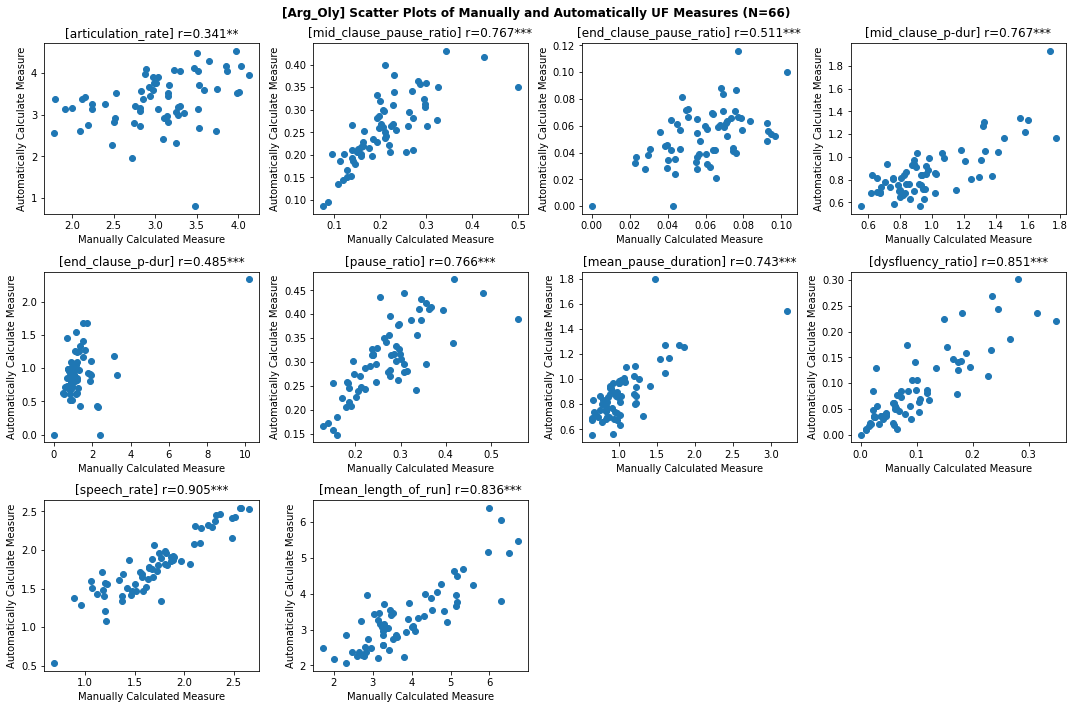

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,Arg_Oly,Mid,0.341121,5.064049e-03,**,0.108005,0.538679
mid_clause_pause_ratio,Arg_Oly,Mid,0.767315,5.732240e-14,***,0.645084,0.851256
end_clause_pause_ratio,Arg_Oly,Mid,0.511493,1.138227e-05,***,0.307532,0.670517
mid_clause_p-dur,Arg_Oly,Mid,0.766699,6.174061e-14,***,0.644210,0.850844
end_clause_p-dur,Arg_Oly,Mid,0.485172,3.647792e-05,***,0.275489,0.650784
pause_ratio,Arg_Oly,Mid,0.766394,6.404135e-14,***,0.643778,0.850640
mean_pause_duration,Arg_Oly,Mid,0.743383,8.759321e-13,***,0.611345,0.835153
dysfluency_ratio,Arg_Oly,Mid,0.851120,1.423627e-19,***,0.767111,0.906429
speech_rate,Arg_Oly,Mid,0.904796,2.047654e-25,***,0.848598,0.940802


In [16]:
task = "Arg_Oly"
rating_filter = [3, 4, 5]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto, pf_group="Mid")
df_cor_list.append(df_pearsonr)
df_pearsonr

**Cartoon**

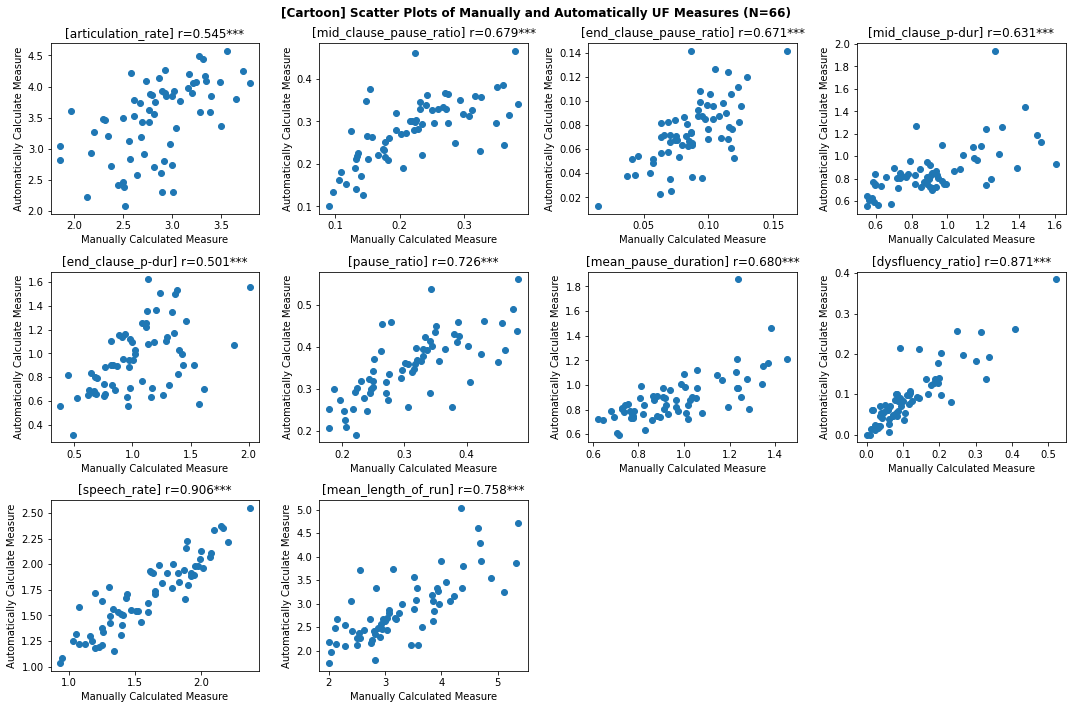

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,Cartoon,Mid,0.545260,2.201050e-06,***,0.349328,0.695506
mid_clause_pause_ratio,Cartoon,Mid,0.678764,3.767810e-10,***,0.522582,0.790870
end_clause_pause_ratio,Cartoon,Mid,0.671116,6.985983e-10,***,0.512297,0.785550
mid_clause_p-dur,Cartoon,Mid,0.631200,1.333758e-08,***,0.459342,0.757508
end_clause_p-dur,Cartoon,Mid,0.501148,1.819720e-05,***,0.294883,0.662788
pause_ratio,Cartoon,Mid,0.725846,5.376043e-12,***,0.586923,0.823251
mean_pause_duration,Cartoon,Mid,0.679601,3.517529e-10,***,0.523712,0.791452
dysfluency_ratio,Cartoon,Mid,0.871378,1.828851e-21,***,0.797550,0.919488
speech_rate,Cartoon,Mid,0.906325,1.249282e-25,***,0.850959,0.941771


In [17]:
task = "Cartoon"
rating_filter = [3, 4, 5]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto, pf_group="Mid")
df_cor_list.append(df_pearsonr)
df_pearsonr

**RtSwithoutRAA**

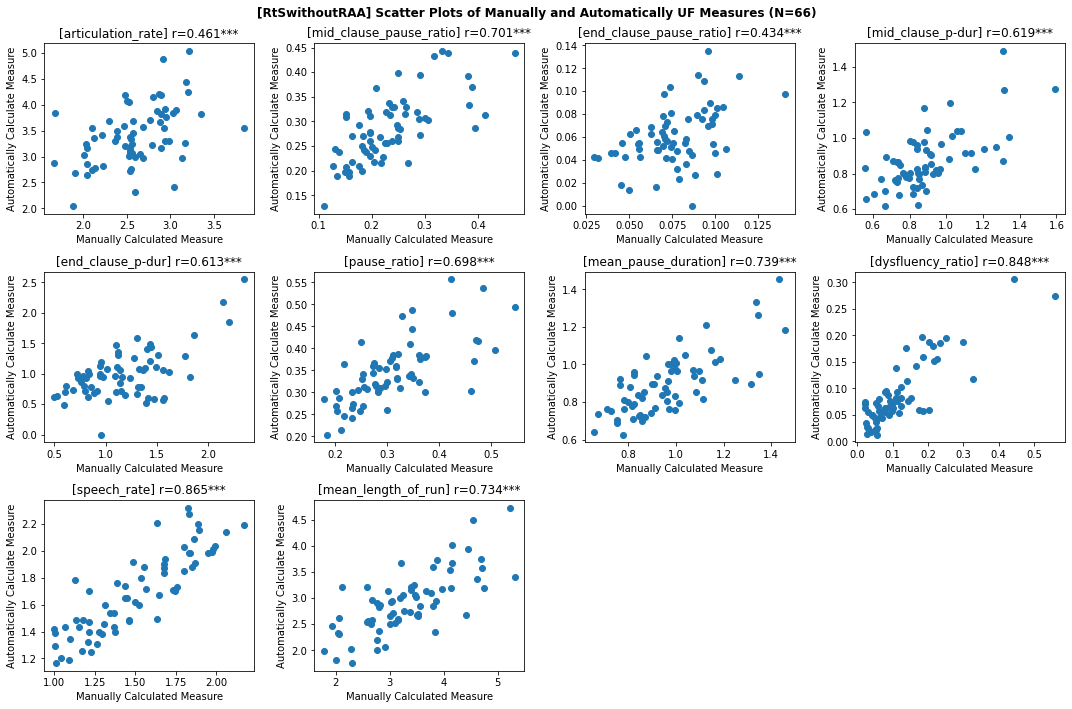

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,RtSwithoutRAA,Mid,0.460619,9.951770e-05,***,0.246013,0.632174
mid_clause_pause_ratio,RtSwithoutRAA,Mid,0.700767,5.727243e-11,***,0.552431,0.806081
end_clause_pause_ratio,RtSwithoutRAA,Mid,0.434381,2.682302e-04,***,0.214946,0.612065
mid_clause_p-dur,RtSwithoutRAA,Mid,0.619215,2.983913e-08,***,0.443676,0.748996
end_clause_p-dur,RtSwithoutRAA,Mid,0.612657,4.570801e-08,***,0.435149,0.744320
pause_ratio,RtSwithoutRAA,Mid,0.698062,7.285362e-11,***,0.548742,0.804219
mean_pause_duration,RtSwithoutRAA,Mid,0.738581,1.460408e-12,***,0.604632,0.831902
dysfluency_ratio,RtSwithoutRAA,Mid,0.848347,2.456858e-19,***,0.762974,0.904633
speech_rate,RtSwithoutRAA,Mid,0.864756,8.199122e-21,***,0.787558,0.915231


In [18]:
task = "RtSwithoutRAA"
rating_filter = [3, 4, 5]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto, pf_group="Mid")
df_cor_list.append(df_pearsonr)
df_pearsonr

**RtSwithRAA**

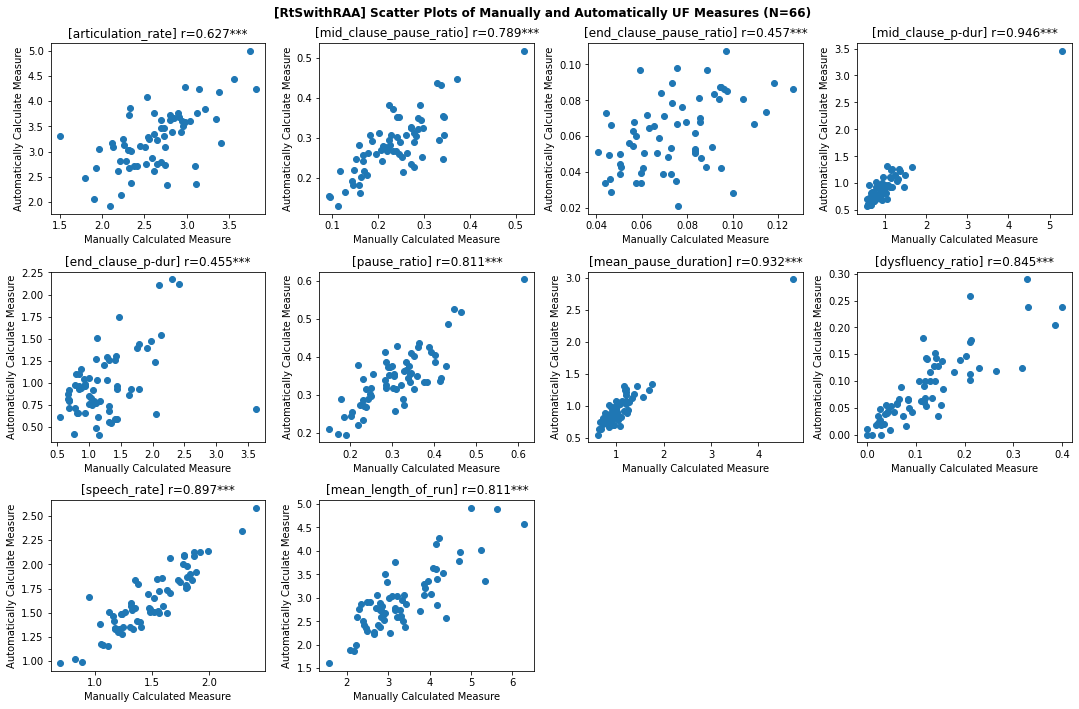

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,RtSwithRAA,Mid,0.627101,1.763486e-08,***,0.453971,0.754601
mid_clause_pause_ratio,RtSwithRAA,Mid,0.788644,3.780729e-15,***,0.675561,0.865477
end_clause_pause_ratio,RtSwithRAA,Mid,0.456702,1.159886e-04,***,0.241347,0.629187
mid_clause_p-dur,RtSwithRAA,Mid,0.945670,6.195045e-33,***,0.912492,0.966490
end_clause_p-dur,RtSwithRAA,Mid,0.455157,1.231488e-04,***,0.239510,0.628007
pause_ratio,RtSwithRAA,Mid,0.810563,1.636390e-16,***,0.707288,0.879962
mean_pause_duration,RtSwithRAA,Mid,0.931960,6.715535e-30,***,0.890879,0.957920
dysfluency_ratio,RtSwithRAA,Mid,0.844933,4.739575e-19,***,0.757890,0.902420
speech_rate,RtSwithRAA,Mid,0.896842,2.354487e-24,***,0.836353,0.935755


In [19]:
task = "RtSwithRAA"
rating_filter = [3, 4, 5]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto, pf_group="Mid")
df_cor_list.append(df_pearsonr)
df_pearsonr

**WoZ_Interview**

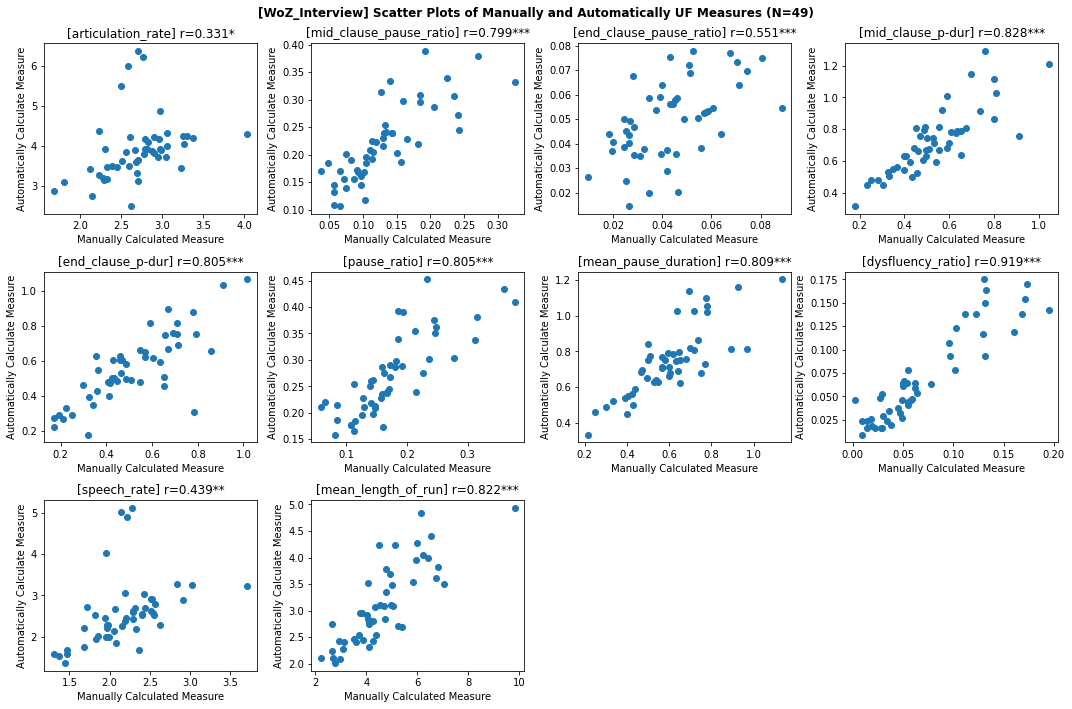

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,WoZ_Interview,Mid,0.331381,2.002237e-02,*,0.055341,0.560361
mid_clause_pause_ratio,WoZ_Interview,Mid,0.799340,5.740964e-12,***,0.668374,0.882235
end_clause_pause_ratio,WoZ_Interview,Mid,0.551077,4.072474e-05,***,0.319371,0.720608
mid_clause_p-dur,WoZ_Interview,Mid,0.828073,2.132923e-13,***,0.712869,0.899759
end_clause_p-dur,WoZ_Interview,Mid,0.805000,3.134038e-12,***,0.677067,0.885706
pause_ratio,WoZ_Interview,Mid,0.805256,3.048041e-12,***,0.677461,0.885862
mean_pause_duration,WoZ_Interview,Mid,0.808684,2.091358e-12,***,0.682742,0.887959
dysfluency_ratio,WoZ_Interview,Mid,0.918623,1.399175e-20,***,0.859428,0.953514
speech_rate,WoZ_Interview,Mid,0.438690,1.615684e-03,**,0.179655,0.640834


In [20]:
task = "WoZ_Interview"
rating_filter = [2, 3]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto, pf_group="Mid")
df_cor_list.append(df_pearsonr)
df_pearsonr

### 3.4. Advanced Speakers

The following code blocks conduct the analyses of *advanced speakers'* speech.

**Arg_Oly**

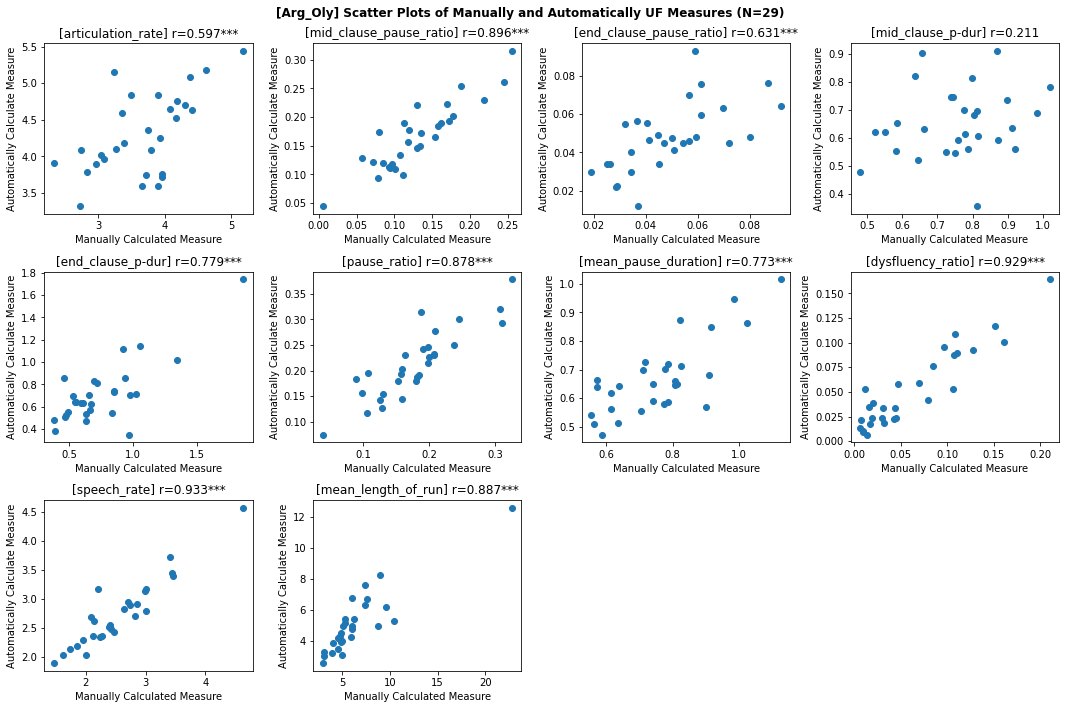

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,Arg_Oly,High,0.597381,6.225787e-04,***,0.295593,0.790756
mid_clause_pause_ratio,Arg_Oly,High,0.896022,5.080391e-11,***,0.788437,0.950414
end_clause_pause_ratio,Arg_Oly,High,0.630799,2.440069e-04,***,0.343769,0.810032
mid_clause_p-dur,Arg_Oly,High,0.210571,2.728900e-01,,-0.168975,0.535731
end_clause_p-dur,Arg_Oly,High,0.779375,6.298314e-07,***,0.577961,0.891288
pause_ratio,Arg_Oly,High,0.878217,3.848455e-10,***,0.754593,0.941637
mean_pause_duration,Arg_Oly,High,0.772504,9.115586e-07,***,0.566347,0.887683
dysfluency_ratio,Arg_Oly,High,0.929424,3.325226e-13,***,0.853734,0.966651
speech_rate,Arg_Oly,High,0.933196,1.620298e-13,***,0.861261,0.968466


In [21]:
task = "Arg_Oly"
rating_filter = [6, 7, 8]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto, pf_group="High")
df_cor_list.append(df_pearsonr)
df_pearsonr

**Cartoon**

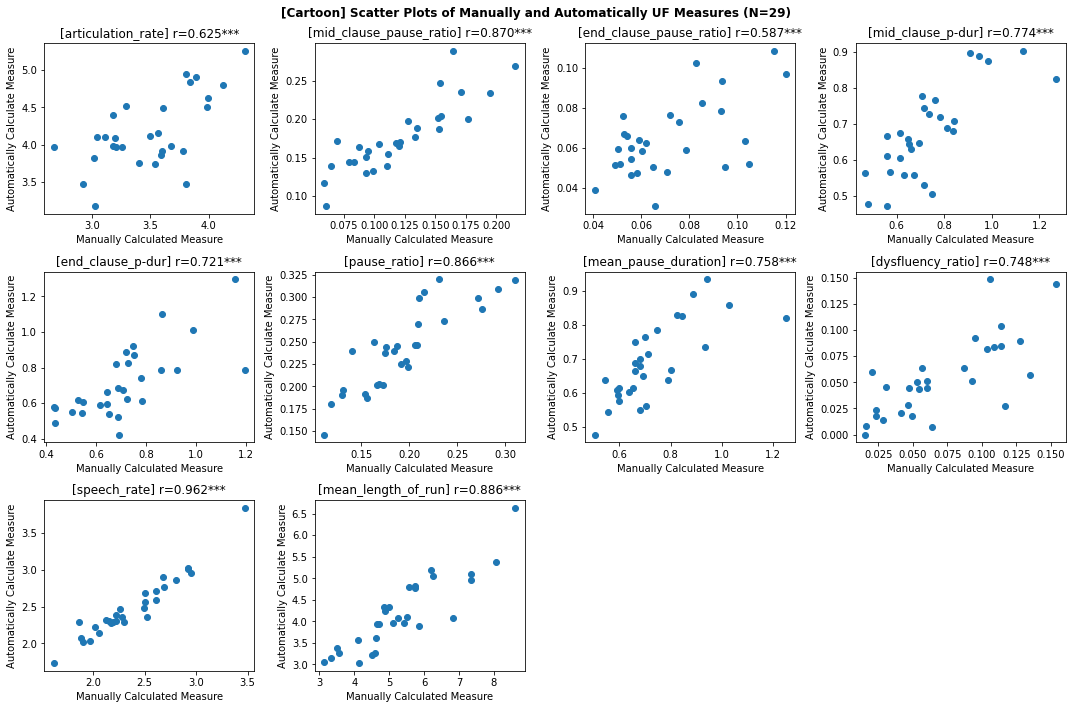

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,Cartoon,High,0.625354,2.863183e-04,***,0.335816,0.806918
mid_clause_pause_ratio,Cartoon,High,0.869722,9.076416e-10,***,0.738674,0.937418
end_clause_pause_ratio,Cartoon,High,0.587261,8.104824e-04,***,0.281301,0.784842
mid_clause_p-dur,Cartoon,High,0.774088,8.380298e-07,***,0.569017,0.888515
end_clause_p-dur,Cartoon,High,0.720867,1.029137e-05,***,0.481602,0.860126
pause_ratio,Cartoon,High,0.866269,1.264811e-09,***,0.732245,0.935698
mean_pause_duration,Cartoon,High,0.757884,1.922319e-06,***,0.541901,0.879963
dysfluency_ratio,Cartoon,High,0.748348,3.043104e-06,***,0.526152,0.874893
speech_rate,Cartoon,High,0.962018,9.410157e-17,***,0.919832,0.982211


In [22]:
task = "Cartoon"
rating_filter = [6, 7, 8]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto, pf_group="High")
df_cor_list.append(df_pearsonr)
df_pearsonr

**RtSwithoutRAA**

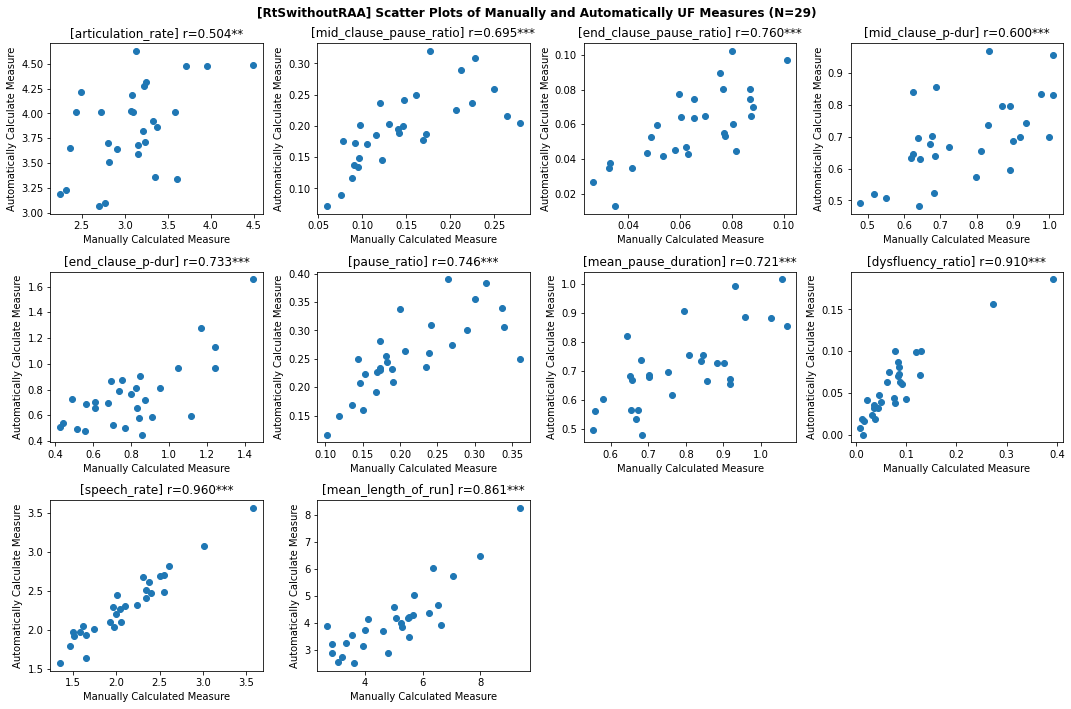

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,RtSwithoutRAA,High,0.504377,5.270102e-03,**,0.169138,0.735011
mid_clause_pause_ratio,RtSwithoutRAA,High,0.695295,2.834200e-05,***,0.441227,0.846171
end_clause_pause_ratio,RtSwithoutRAA,High,0.759839,1.745017e-06,***,0.545149,0.880999
mid_clause_p-dur,RtSwithoutRAA,High,0.599811,5.835998e-04,***,0.299046,0.792170
end_clause_p-dur,RtSwithoutRAA,High,0.732536,6.245339e-06,***,0.500369,0.866425
pause_ratio,RtSwithoutRAA,High,0.746467,3.323852e-06,***,0.523063,0.873890
mean_pause_duration,RtSwithoutRAA,High,0.720814,1.031429e-05,***,0.481517,0.860097
dysfluency_ratio,RtSwithoutRAA,High,0.909586,8.359080e-12,***,0.814664,0.957044
speech_rate,RtSwithoutRAA,High,0.959513,2.196216e-16,***,0.914665,0.981025


In [23]:
task = "RtSwithoutRAA"
rating_filter = [6, 7, 8]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto, pf_group="High")
df_cor_list.append(df_pearsonr)
df_pearsonr

**RtSwithRAA**

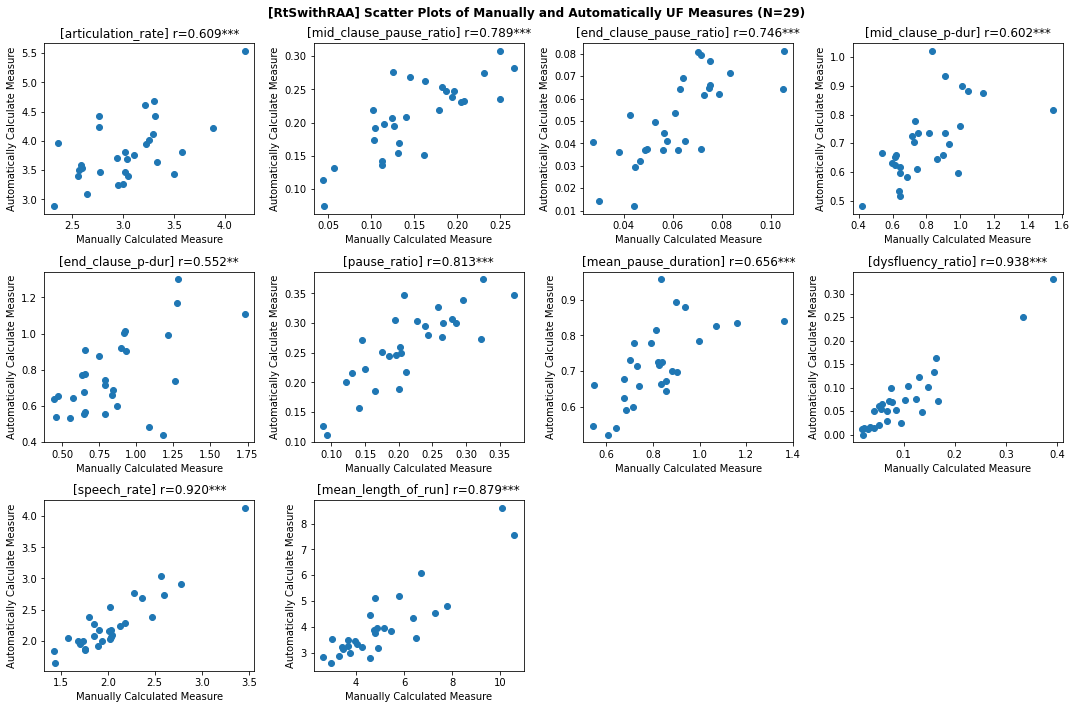

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,RtSwithRAA,High,0.608741,4.581266e-04,***,0.311800,0.797352
mid_clause_pause_ratio,RtSwithRAA,High,0.788724,3.727592e-07,***,0.593898,0.896172
end_clause_pause_ratio,RtSwithRAA,High,0.745827,3.424446e-06,***,0.522014,0.873549
mid_clause_p-dur,RtSwithRAA,High,0.602108,5.487359e-04,***,0.302317,0.793506
end_clause_p-dur,RtSwithRAA,High,0.552041,1.904387e-03,**,0.232595,0.763974
pause_ratio,RtSwithRAA,High,0.813302,8.209926e-08,***,0.636535,0.908887
mean_pause_duration,RtSwithRAA,High,0.656185,1.110506e-04,***,0.381406,0.824421
dysfluency_ratio,RtSwithRAA,High,0.937659,6.544407e-14,***,0.870206,0.970608
speech_rate,RtSwithRAA,High,0.919710,1.788529e-12,***,0.834495,0.961959


In [24]:
task = "RtSwithRAA"
rating_filter = [6, 7, 8]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto, pf_group="High")
df_cor_list.append(df_pearsonr)
df_pearsonr

**WoZ_Interview**

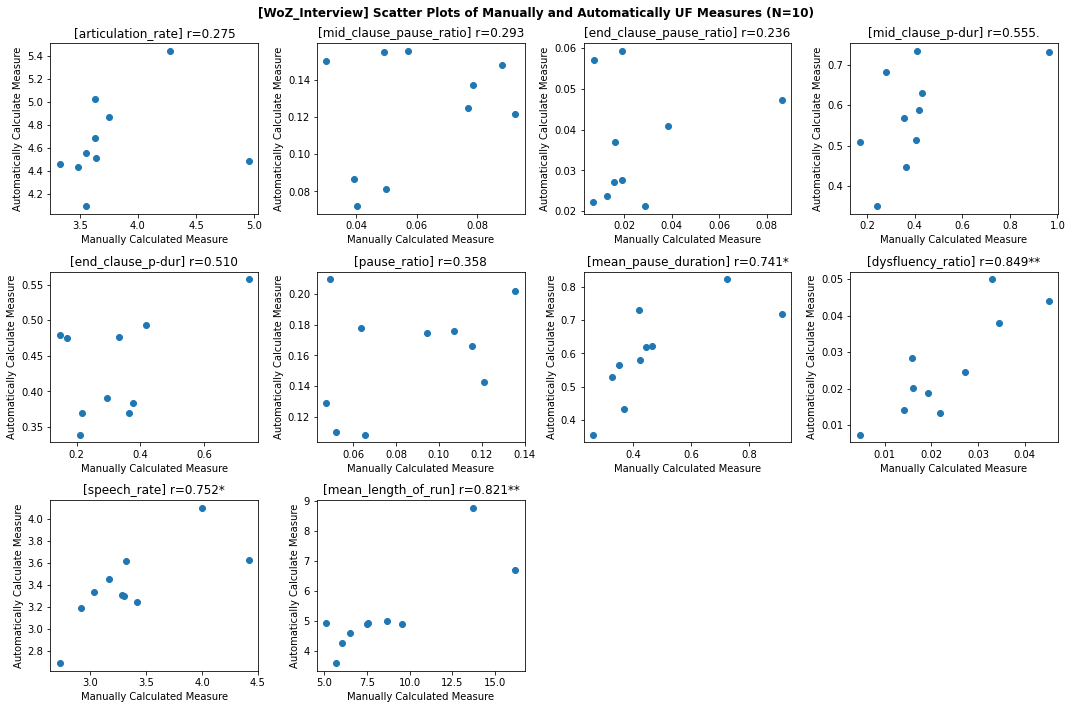

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,WoZ_Interview,High,0.274718,0.442391,,-0.429136,0.770987
mid_clause_pause_ratio,WoZ_Interview,High,0.292776,0.411684,,-0.412978,0.778833
end_clause_pause_ratio,WoZ_Interview,High,0.235832,0.511864,,-0.462463,0.753565
mid_clause_p-dur,WoZ_Interview,High,0.555400,0.095564,.,-0.114140,0.877996
end_clause_p-dur,WoZ_Interview,High,0.509576,0.132445,,-0.176763,0.862482
pause_ratio,WoZ_Interview,High,0.358494,0.309045,,-0.350172,0.806157
mean_pause_duration,WoZ_Interview,High,0.741412,0.014122,*,0.209656,0.934706
dysfluency_ratio,WoZ_Interview,High,0.849097,0.001883,**,0.471588,0.963580
speech_rate,WoZ_Interview,High,0.751891,0.012135,*,0.232183,0.937632


In [25]:
task = "WoZ_Interview"
rating_filter = [4, 5]
df_uf_manu, df_uf_auto = load_measures([task], rating_filter)
df_pearsonr = correlation_analysis(task, df_uf_manu, df_uf_auto, pf_group="High")
df_cor_list.append(df_pearsonr)
df_pearsonr

### 3.5 Summary

In [26]:
df_cor_all = pd.concat(df_cor_list)
df_cor_all.to_csv("/home/matsuura/Development/app/feature_extraction_api/experiment/data/correlation_all_results_mask_RtoS2055.csv")
df_cor_all

,task,PF,r,p,sig,lower,upper
UF measure,,,,,,,
articulation_rate,All Task,All,0.581867,2.706997e-55,***,0.526142,0.632617
mid_clause_pause_ratio,All Task,All,0.803635,5.318802e-136,***,0.773228,0.830355
end_clause_pause_ratio,All Task,All,0.553370,4.105157e-49,***,0.495059,0.606719
mid_clause_p-dur,All Task,All,0.848405,3.075166e-166,***,0.824256,0.869474
end_clause_p-dur,All Task,All,0.719307,4.809989e-96,***,0.678172,0.755949
...,...,...,...,...,...,...,...
pause_ratio,WoZ_Interview,High,0.358494,3.090453e-01,,-0.350172,0.806157
mean_pause_duration,WoZ_Interview,High,0.741412,1.412155e-02,*,0.209656,0.934706
dysfluency_ratio,WoZ_Interview,High,0.849097,1.883119e-03,**,0.471588,0.963580
